In [3]:
# %load_ext autoreload
# %autoreload 2

In [22]:
 
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import requests
import h5py
from pathlib import Path
import concurrent.futures
from tqdm import tqdm
from json import JSONDecodeError
from dotenv import load_dotenv
load_dotenv()
from time import sleep
import multiprocessing as mp
import pandas as pd
from itertools import starmap
import requests
from earthdata_login import get_session

from rasterio.windows import transform as get_window_transform
from rasterio.transform import rowcol
from shapely.geometry import box
import rasterio
from shapely.geometry import GeometryCollection
from rasterio.windows import from_bounds as window_from_bounds
from rasterio import default_gtiff_profile
from rasterio.transform import array_bounds
from rasterio import features

from nasadem_val.filter_routines import (get_pixel_values,
                                         get_raster_from_window,
                                         get_pixel_values_from_raster_window)
from nasadem_val.rtree import obtain_intersection_point_mask
from nasadem_val.geojson_io import (to_geojson_gzip,
                                    read_geojson_gzip)
from nasadem_val.nasadem_io import (load_nasadem_hgt_zip, 
                                    get_profile_from_zip_file, 
                                    get_nasadem_data,
                                    get_dem_slope)

In [2]:
GEDI_ORBIT_DIR = Path('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw')
GEDI_ORBIT_DIR.exists()

True

In [3]:
GEDI_AGG_DIR = Path('/mnt/phh-r0c/users/cmarshak/gedi_nasadem_aggregated')
GEDI_AGG_DIR.mkdir(exist_ok=True, parents=True)

In [4]:
DATA_DIR = '/mnt/phh-r0c/users/cmarshak/'

In [5]:
gedi_files = list(GEDI_ORBIT_DIR.glob('*/*.geojson.gzip'))
gedi_files[:2], len(gedi_files)

([PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Australia/s29e141__GEDI02_A_2019127013522_O02255_T03578_02_001_01.geojson.gzip'),
  PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Australia/s29e125__GEDI02_A_2019128021818_O02271_T02018_02_001_01.geojson.gzip')],
 271097)

In [6]:
df_tile_agg = pd.read_pickle('df_tile_agg.pkl')
df_tile_agg.head()

,nasadem_tile_name,raw_gedi_data_path,nasadem_tile_path,continent,bounds
0,n00e006,[/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/A...,/mnt/phh-r0b/nasadem/daac/Africa/hgt_merge/n00...,Africa,"(6.0, -0.0002777777777778212, 7.00027777777777..."
1,n00e009,[/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/A...,/mnt/phh-r0b/nasadem/daac/Africa/hgt_merge/n00...,Africa,"(9.0, -0.0002777777777778212, 10.0002777777777..."
2,n00e010,[/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/A...,/mnt/phh-r0b/nasadem/daac/Africa/hgt_merge/n00...,Africa,"(10.0, -0.0002777777777778212, 11.000277777777..."
3,n00e011,[/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/A...,/mnt/phh-r0b/nasadem/daac/Africa/hgt_merge/n00...,Africa,"(11.0, -0.0002777777777778212, 12.000277777777..."
4,n00e012,[/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/A...,/mnt/phh-r0b/nasadem/daac/Africa/hgt_merge/n00...,Africa,"(12.0, -0.0002777777777778212, 13.000277777777..."


In [7]:
tile_records = df_tile_agg.to_dict('records')
tile_records[0]

{'nasadem_tile_name': 'n00e006',
 'raw_gedi_data_path': [PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Africa/n00e006__GEDI02_A_2019207140011_O03505_T02627_02_001_01.geojson.gzip'),
  PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Africa/n00e006__GEDI02_A_2019156101617_O02711_T02780_02_001_01.geojson.gzip'),
  PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Africa/n00e006__GEDI02_A_2019163183210_O02825_T05220_02_001_02.geojson.gzip'),
  PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Africa/n00e006__GEDI02_A_2019189082236_O03222_T02527_02_001_01.geojson.gzip'),
  PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Africa/n00e006__GEDI02_A_2019167060146_O02879_T02321_02_001_01.geojson.gzip'),
  PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Africa/n00e006__GEDI02_A_2019182000544_O03108_T02933_02_001_01.geojson.gzip'),
  PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Africa/n00e006__GEDI02_A_2019174141727_O02993_T00492_02_001_01.geojson.g

In [8]:
def get_one_gedi_df(path):
    df = read_geojson_gzip(path)
    return df

def get_all_gedi_data_for_tile(tile_entry):
    paths = tile_entry['raw_gedi_data_path']
    dfs = list(map(get_one_gedi_df, tqdm(paths)))
    df = pd.concat(dfs, axis=0).reset_index(drop=True)
    return df

In [9]:
df = get_all_gedi_data_for_tile(tile_records[0])
df.head()

  0%|          | 0/13 [00:00<?, ?it/s]/mnt/phh-r0c/users/cmarshak/anaconda3/envs/gis/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


,geometry,beam,channel,degrade_flag,delta_time,digital_elevation_model,elev_highestreturn,elev_lowestmode,elevation_bias_flag,elevation_bin0_error,...,shot_number,solar_azimuth,solar_elevation,surface_flag,landsat_treecover,modis_nonvegetated,modis_nonvegetated_sd,modis_treecover,modis_treecover_sd,orbit_name
0,POINT (6.00003 0.06393),0,0,0,4.938619e+07,-999999.0,19.072321,16.411947,1,0.258248,...,35050003000091202,-61.347122,46.432766,1,0.0,-9999.0,0.0,-9999.0,0.0,GEDI02_A_2019207140011_O03505_T02627_02_001_01.h5
1,POINT (6.00033 0.06435),0,0,0,4.938619e+07,-999999.0,18.510057,15.737273,1,0.258247,...,35050003200091203,-61.347675,46.432678,1,0.0,-9999.0,0.0,-9999.0,0.0,GEDI02_A_2019207140011_O03505_T02627_02_001_01.h5
2,POINT (6.00062 0.06477),0,0,0,4.938619e+07,-999999.0,19.217592,16.894453,1,0.258245,...,35050003400091204,-61.348228,46.432587,1,0.0,-9999.0,0.0,-9999.0,0.0,GEDI02_A_2019207140011_O03505_T02627_02_001_01.h5
3,POINT (6.00092 0.06519),0,0,0,4.938619e+07,-999999.0,18.968287,16.457911,1,0.258244,...,35050003600091205,-61.348782,46.432499,1,0.0,-9999.0,0.0,-9999.0,0.0,GEDI02_A_2019207140011_O03505_T02627_02_001_01.h5
4,POINT (6.00121 0.06561),0,0,0,4.938619e+07,-999999.0,20.331656,17.858644,1,0.258242,...,35050003800091206,-61.349335,46.432411,1,0.0,-9999.0,0.0,-9999.0,0.0,GEDI02_A_2019207140011_O03505_T02627_02_001_01.h5


In [10]:
df.shape, df.columns

((117468, 41),
 Index(['geometry', 'beam', 'channel', 'degrade_flag', 'delta_time',
        'digital_elevation_model', 'elev_highestreturn', 'elev_lowestmode',
        'elevation_bias_flag', 'elevation_bin0_error', 'energy_total',
        'lat_highestreturn', 'lat_lowestmode', 'latitude_bin0_error',
        'lon_highestreturn', 'lon_lowestmode', 'longitude_bin0_error',
        'master_frac', 'master_int', 'mean_sea_surface', 'num_detectedmodes',
        'quality_flag', 'rh_0', 'rh_25', 'rh_50', 'rh_75', 'rh_98', 'rh_100',
        'selected_algorithm', 'selected_mode', 'sensitivity', 'shot_number',
        'solar_azimuth', 'solar_elevation', 'surface_flag', 'landsat_treecover',
        'modis_nonvegetated', 'modis_nonvegetated_sd', 'modis_treecover',
        'modis_treecover_sd', 'orbit_name'],
       dtype='object'))

In [11]:
GLOBAL_WATER_MASK_PATH = '/mnt/phh-r0c/users/cmarshak/hydropolys/'
with rasterio.open('/mnt/phh-r0c/users/cmarshak/geoids/egm96-15.tif') as ds:
    GEOID_RASTER = ds.read(1)
    GEOID_PROFILE = ds.profile

In [12]:
PECKEL_OCCURENCE_PATH = Path('/mnt/phh-r0c/users/cmarshak/peckel_data/occurrence.kea')
PECKEL_OCCURENCE_PATH.exists()

True

In [13]:
GLIMS_GEOMETRY_PATH = '/mnt/phh-r0c/users/mdenbina/glims/glims_polygons_buffered.shp'

In [14]:
def append_nasadem_data(df, nasadem_path):
    if df.empty:
        return df 
    height, nasadem_profile = get_nasadem_data(nasadem_path)
    slope = get_dem_slope(height, nasadem_profile['transform'])
    
    height_series, slope_series = get_pixel_values(df.geometry, 
                                                   [height, slope], 
                                                   nasadem_profile)

    df['nasadem'] = height_series
    df['nasadem_slope_degrees'] = slope_series
    return df


def append_egm96_data(df):
    if df.empty:
        return df
    
    egm_series = get_pixel_values(df.geometry, GEOID_RASTER, GEOID_PROFILE)
    df['egm_96'] = egm_series
    return df

def append_peckel_occurrence_data(df):
    window_extent = df.total_bounds
    peckel_series = get_pixel_values_from_raster_window(df.geometry, 
                                                        window_extent, 
                                                        PECKEL_OCCURENCE_PATH)
    df['peckel_occurrence'] = peckel_series
    return df

def append_buffered_glims(df, nasadem_path):
    nasadem_p = get_profile_from_zip_file(test_record['nasadem_tile_path'])
    nasadem_bounds = array_bounds(nasadem_p['height'], nasadem_p['width'], nasadem_p['transform'])
    
    df_geometry = gpd.read_file(GLIMS_GEOMETRY_PATH, bbox=tuple(nasadem_bounds))
    
    if df_geometry.empty:
        df['glim_buffered'] = 0
        
    else:
        box_geo = box(*nasadem_bounds)
        mask_geometry = df_geometry.geometry.intersection(box_geo).geometry.unary_union
        mask = rasterize_shapes_to_array([mask_geometry], [1], p, all_touched=True, fill_value=0)

        glim_series = get_pixel_values(df.geometry, 
                                       mask,
                                       nasadem_p)

        df['glim_buffered'] = glim_series
    return df

# Tests

In [15]:
TEST_INDEX = 1
test_record = tile_records[TEST_INDEX]


# tile_name = 's49w073'#'s50w074'
# TEST_INDEX = [k for k in range(len(tile_records)) if tile_name in tile_records[k]['nasadem_tile_name']][0]
test_record = tile_records[TEST_INDEX]
test_record

{'nasadem_tile_name': 'n00e009',
 'raw_gedi_data_path': [PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Africa/n00e009__GEDI02_A_2019111040155_O02008_T04616_02_001_01.geojson.gzip'),
  PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Africa/n00e009__GEDI02_A_2019118011926_O02115_T02887_02_001_01.geojson.gzip'),
  PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Africa/n00e009__GEDI02_A_2019146011955_O02550_T02940_02_001_01.geojson.gzip'),
  PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Africa/n00e009__GEDI02_A_2019164065420_O02833_T03499_02_001_01.geojson.gzip'),
  PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Africa/n00e009__GEDI02_A_2019124223647_O02222_T05580_02_001_01.geojson.gzip'),
  PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Africa/n00e009__GEDI02_A_2019197050212_O03344_T01670_02_001_01.geojson.gzip'),
  PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Africa/n00e009__GEDI02_A_2019156210541_O02718_T01058_02_001_01.geojson.g

In [16]:
df = get_all_gedi_data_for_tile(test_record)
#df = df[:2000].copy()
df.head()

  0%|          | 0/14 [00:00<?, ?it/s]/mnt/phh-r0c/users/cmarshak/anaconda3/envs/gis/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
100%|██████████| 14/14 [00:09<00:00,  1.48it/s]


,geometry,beam,channel,degrade_flag,delta_time,digital_elevation_model,elev_highestreturn,elev_lowestmode,elevation_bias_flag,elevation_bin0_error,...,shot_number,solar_azimuth,solar_elevation,surface_flag,landsat_treecover,modis_nonvegetated,modis_nonvegetated_sd,modis_treecover,modis_treecover_sd,orbit_name
0,POINT (9.30436 0.00010),0,0,0,4.105589e+07,-999999.0,14.738804,11.816985,1,0.281086,...,20080002200050566,77.782059,-14.156668,1,0.0,-9999.0,0.0,-9999.0,0.0,GEDI02_A_2019111040155_O02008_T04616_02_001_01.h5
1,POINT (9.30466 0.00052),0,0,0,4.105589e+07,-999999.0,14.808938,11.699823,1,0.281087,...,20080002400050567,77.781967,-14.156255,1,0.0,-9999.0,0.0,-9999.0,0.0,GEDI02_A_2019111040155_O02008_T04616_02_001_01.h5
2,POINT (9.30496 0.00095),0,0,0,4.105589e+07,-999999.0,14.582099,11.735198,1,0.281089,...,20080002600050568,77.781883,-14.155842,1,0.0,-9999.0,0.0,-9999.0,0.0,GEDI02_A_2019111040155_O02008_T04616_02_001_01.h5
3,POINT (9.30525 0.00137),0,0,0,4.105589e+07,-999999.0,14.664258,11.667521,1,0.281090,...,20080002800050569,77.781799,-14.155428,1,0.0,-9999.0,0.0,-9999.0,0.0,GEDI02_A_2019111040155_O02008_T04616_02_001_01.h5
4,POINT (9.30555 0.00179),0,0,0,4.105589e+07,-999999.0,14.658381,11.586724,1,0.281091,...,20080003000050570,77.781708,-14.155015,1,0.0,-9999.0,0.0,-9999.0,0.0,GEDI02_A_2019111040155_O02008_T04616_02_001_01.h5


In [17]:
out_test_dir = Path(f'test_inspection/{TEST_INDEX}')
out_test_dir.mkdir(exist_ok=True, parents=True)

## Test EGM

In [18]:
df = append_egm96_data(df)

## Test NASADEM

In [19]:
df = append_nasadem_data(df, test_record['nasadem_tile_path'])

In [20]:
height, nd_profile = get_nasadem_data(test_record['nasadem_tile_path'])

nd_profile['dtype'] = 'int32'
with rasterio.open(out_test_dir/'nasadem.tif', 'w', **nd_profile) as ds:
    ds.write(height.astype(np.int32), 1)
    
slope = get_dem_slope(height, nd_profile['transform'])

nd_profile['dtype'] = 'float32'
with rasterio.open(out_test_dir/'nasadem_slope.tif', 'w', **nd_profile) as ds:
    ds.write(slope.astype(np.float32), 1)
    

## Test Peckel

In [23]:
df = append_peckel_occurrence_data(df)

In [24]:
window_extent = df.total_bounds
peckel_series = get_pixel_values_from_raster_window(df.geometry, 
                                                    window_extent, 
                                                    PECKEL_OCCURENCE_PATH)

In [25]:
peckel_series.shape

(173400,)

In [26]:
df['peckel_occurrence'] = peckel_series

In [27]:
raster_file_path = PECKEL_OCCURENCE_PATH
window_arr, window_profile = get_raster_from_window(raster_file_path, df.total_bounds)

with rasterio.open(out_test_dir/'peckel_window.tif', 'w', **window_profile) as ds:
    ds.write(window_arr, 1)

## Test Glims

In [28]:
nasadem_p = get_profile_from_zip_file(test_record['nasadem_tile_path'])
nasadem_bounds = array_bounds(nasadem_p['height'], nasadem_p['width'], nasadem_p['transform'])

df_geometry = gpd.read_file(GLIMS_GEOMETRY_PATH, bbox=tuple(nasadem_bounds))
if df_geometry.empty:
    mask = np.zeros((nasadem_p['height'], nasadem_p['width']), dtype=np.int16)
else:
    box_geo = box(*nasadem_bounds)
    mask_geometry = df_geometry.geometry.intersection(box_geo).geometry.unary_union
    mask = rasterize_shapes_to_array([mask_geometry], [1], nasadem_p, all_touched=True, fill_value=0)

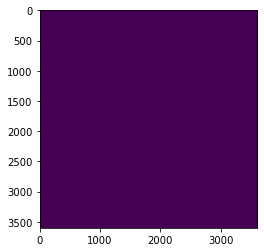

In [29]:
plt.imshow(mask)

In [30]:
with rasterio.open(out_test_dir/'glims_mask.tif', 'w', **nasadem_p) as ds:
    ds.write(mask, 1)

In [31]:
df = append_buffered_glims(df, test_record['nasadem_tile_path'])

## Write

In [32]:
df.to_file(out_test_dir/'test_dataframe')

# Final Composition

In [69]:
def composed_filtering(df, nasadem_path):
    df = append_egm96_data(df)
    df = append_nasadem_data(df, nasadem_path)
    df = append_peckel_occurrence_data(df)
    df = append_buffered_glims(df, nasadem_path)
    return df

def get_filtered_gedi_data(tile_entry):
    df = get_all_gedi_data_for_tile(tile_entry)
    nasadem_path = str(tile_entry['nasadem_tile_path'])
    df = composed_filtering(df, nasadem_path)
    return df

In [70]:
tile_records[1]

{'nasadem_tile_name': 'n00e009',
 'raw_gedi_data_path': [PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Africa/n00e009__GEDI02_A_2019111040155_O02008_T04616_02_001_01.geojson.gzip'),
  PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Africa/n00e009__GEDI02_A_2019118011926_O02115_T02887_02_001_01.geojson.gzip'),
  PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Africa/n00e009__GEDI02_A_2019146011955_O02550_T02940_02_001_01.geojson.gzip'),
  PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Africa/n00e009__GEDI02_A_2019164065420_O02833_T03499_02_001_01.geojson.gzip'),
  PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Africa/n00e009__GEDI02_A_2019124223647_O02222_T05580_02_001_01.geojson.gzip'),
  PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Africa/n00e009__GEDI02_A_2019197050212_O03344_T01670_02_001_01.geojson.gzip'),
  PosixPath('/mnt/phh-r0c/users/cmarshak/gedi_orbits_raw/Africa/n00e009__GEDI02_A_2019156210541_O02718_T01058_02_001_01.geojson.g

In [73]:
df = get_filtered_gedi_data(tile_records[3])
df.head()

  0%|          | 0/18 [00:00<?, ?it/s]/mnt/phh-r0c/users/cmarshak/anaconda3/envs/gis/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
100%|██████████| 18/18 [00:11<00:00,  1.63it/s]


,geometry,beam,channel,degrade_flag,delta_time,digital_elevation_model,elev_highestreturn,elev_lowestmode,elevation_bias_flag,elevation_bin0_error,...,modis_nonvegetated,modis_nonvegetated_sd,modis_treecover,modis_treecover_sd,orbit_name,egm_96,nasadem,nasadem_slope_degrees,peckel_occurrence,glim_buffered
0,POINT (11.99683 0.99958),5,2,0,4.109757e+07,540.140137,557.554504,544.032715,0,0.310530,...,16.0,13.58,57.0,13.58,GEDI02_A_2019111145043_O02015_T00201_02_001_01.h5,9.161,517,0.942134,0,0
1,POINT (11.99713 0.99916),5,2,0,4.109757e+07,532.874329,550.319397,519.680115,0,0.310533,...,16.0,13.58,57.0,13.58,GEDI02_A_2019111145043_O02015_T00201_02_001_01.h5,9.161,513,3.375906,0,0
2,POINT (11.99743 0.99873),5,2,0,4.109757e+07,531.667908,548.201538,518.236450,0,0.310534,...,16.0,13.58,57.0,13.58,GEDI02_A_2019111145043_O02015_T00201_02_001_01.h5,9.161,512,1.321156,0,0
3,POINT (11.99773 0.99831),5,2,0,4.109757e+07,531.667908,542.038269,514.020935,0,0.310536,...,14.0,12.84,58.0,12.84,GEDI02_A_2019111145043_O02015_T00201_02_001_01.h5,9.161,513,3.957862,0,0
4,POINT (11.99802 0.99789),5,2,0,4.109757e+07,527.911133,548.071899,543.165161,0,0.310536,...,15.0,12.23,58.0,12.23,GEDI02_A_2019111145043_O02015_T00201_02_001_01.h5,9.161,518,2.077779,0,0


In [ ]:
def write_nasadem_gedi_tile(tile_entry):
    df = get_filtered_gedi_data(tile_entry)
    tile_name = tile_entry['nasadem_tile_name']
    continent = tile_entry['continent']
    
    dest_dir = GEDI_AGG_DIR/continent
    dest_dir.mkdir(exist_ok=True, parents=True)
    dest_path = dest_dir/f'{tile_name}.geojson.gzip'
    
    to_geojson_gzip(df, dest_path)
    tile_entry['dest_path'] = dest_path
    return tile_entry

In [ ]:
write_nasadem_gedi_tile(tile_records[1])

In [ ]:
NPROC = 20
with mp.Pool(NPROC) as p:
    new_records = p.map(write_nasadem_gedi_tile, tqdm(tile_records))


In [ ]:
df.geometry, 
                                                        window_extent, 
                                                        PECKEL_OCCURENCE_PATH